In [4]:
import os
import datetime
import copy
import torch
from torch.nn import Module
import tqdm
import numpy as np 
import gym
from gym import Env
from gym.spaces import Box
from gym .utils.env_checker import check_env
from typing import (
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import stable_baselines3
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

In [5]:
print(stable_baselines3.__version__)
print(gym.__version__) # should be 0.21.0 to be compatible with stable_baselines3 1.8

1.8.0
0.21.0



#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

In [6]:
N = 100 # number of datapoints 
xvalues = np.linspace(-2, 2, N) # sequences from -3 to 3 with N values

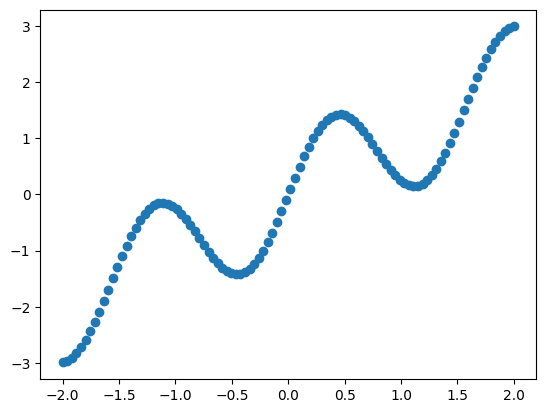

In [7]:
sine_wave = xvalues + np.sin(4*xvalues)
plt.plot(xvalues, sine_wave, 'o');

In [8]:
# y
sine_wave

array([-2.98935825, -2.95947432, -2.90353058, -2.82193204, -2.71575235,
       -2.58670583, -2.43710276, -2.26978919, -2.08807276, -1.89563649,
       -1.69644281, -1.49463023, -1.29440554, -1.09993415, -0.91523152,
       -0.74405849, -0.58982329, -0.4554927 , -0.34351473, -0.25575481,
       -0.19344717, -0.15716269, -0.14679399, -0.16155828, -0.20001769,
       -0.2601168 , -0.33923622, -0.4342608 , -0.54166086, -0.6575842 ,
       -0.77795645, -0.89858731, -1.01527972, -1.12393929, -1.22068097,
       -1.30193034, -1.36451675, -1.40575595, -1.42352009, -1.41629312,
       -1.38321035, -1.32408098, -1.23939303, -1.13030068, -0.99859414,
       -0.84665305, -0.67738437, -0.49414671, -0.30066274, -0.10092218,
        0.10092218,  0.30066274,  0.49414671,  0.67738437,  0.84665305,
        0.99859414,  1.13030068,  1.23939303,  1.32408098,  1.38321035,
        1.41629312,  1.42352009,  1.40575595,  1.36451675,  1.30193034,
        1.22068097,  1.12393929,  1.01527972,  0.89858731,  0.77

In [9]:
def build_model():
    return torch.nn.Sequential(
        torch.nn.Linear(1, 24),
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 1
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 2
        torch.nn.ReLU(),
        torch.nn.Linear(24, 1)
    )

def save_model(model: torch.nn.Module,path: str) -> None:
    torch.save(model.state_dict(), path)

def load_model(model: torch.nn.Module, path: str) -> torch.nn.Module:
    model.load_state_dict(torch.load(path))    
    
def split_data(X: np.ndarray,
               y: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # wraps sklearn's train_test_split
    # added functionality is converting to torch tensor type and reshaping
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

def train_regression_model(model: torch.nn.Module,
                           opt: torch.optim,
                           X_train: torch.Tensor, 
                           y_train: torch.Tensor, 
                           X_test: torch.Tensor, 
                           y_test: torch.Tensor, 
                           save_path: str,
                           n_epochs: int=500, 
                           batch_size: int=1,
                           show_progress: bool=True) -> Tuple[List[torch.Tensor], 
                                                              List[torch.Tensor], 
                                                              float, 
                                                              OrderedDict[str, torch.tensor]]:
    loss_fn = torch.nn.MSELoss()
    best_mse = np.inf
    best_weights = None
    loss_history = []
    prediction_history = []
    
    ##############
    # 500 epochs 
    ##############
    for epoch in range(n_epochs):
        # train model on batches (which here is just a singular value)
        model.train()
        ################
        # 100 samples 
        ################
        if show_progress:
            pbar = tqdm.tqdm(total=len(X_train))
            pbar.set_description(f"Epoch {epoch}")
        for batch_index in range(round(len(X_train)/batch_size)):
            ################
            # 1 sample at a time (batch size = 1)
            ################
            X_batch = X_train[batch_index : batch_index + batch_size]
            y_batch = y_train[batch_index : batch_index + batch_size]

            # forward pass
            y_pred = model(X_batch)
            
            loss = loss_fn(y_pred, y_batch)

            # update weights via backprop
            opt.zero_grad()
            loss.backward()
            opt.step()

            if show_progress: pbar.update(10)
        if show_progress: pbar.close()

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        loss_history.append(mse)
        prediction_history.append(y_pred)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
            # torch.save({'epoch': epoch+1,
            #             'model_state_dict': model.state_dict(),
            #             'optimizer_state_dict': opt.state_dict(),
            #             }, save_path)        
    
    return prediction_history, loss_history, best_mse, best_weights


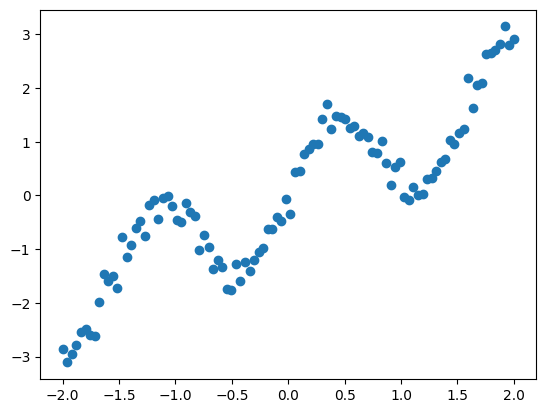

In [10]:
noisy_sine_wave = xvalues + np.sin(4*xvalues) + np.random.normal(0,0.2, 100)
plt.plot(xvalues, noisy_sine_wave, 'o');

In [11]:
x_for_split = xvalues.reshape((N,1))
X_train, y_train, X_test, y_test = split_data(x_for_split, sine_wave)
noisy_X_train, noisy_y_train, noisy_X_test, noisy_y_test = split_data(x_for_split, noisy_sine_wave)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


torch.Size([70, 1])
torch.Size([70, 1])
torch.Size([30, 1])
torch.Size([30, 1])


In [12]:
x_for_split.shape

(100, 1)

In [13]:
sine_wave.shape

(100,)

In [14]:
# depiction of how batch training works (i.e., that you just returned a 
# vector with as the same # of outputs and you passed inputs)
model = build_model()
print(X_train[0:5])
print(model(X_train[0:5]))
print()
print(X_train[0])
print(model(X_train[0]))

tensor([[ 0.9495],
        [ 1.6364],
        [ 0.3434],
        [-1.4747],
        [-0.0606]])
tensor([[0.0381],
        [0.0551],
        [0.0232],
        [0.0252],
        [0.0220]], grad_fn=<AddmmBackward0>)

tensor([0.9495])
tensor([0.0381], grad_fn=<AddBackward0>)


# Global training params

In [15]:
NUM_LAYERS=5
NUM_NODES=32
SEED=12
LOSS_FN=torch.nn.MSELoss()
EPOCHS=1000
PATH=os.path.join(os.path.abspath(""), f"model-{datetime.datetime.now()}.pth")
MODEL=build_model()
OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)

def reset_env():
    DEFAULT_NUM_LAYERS=100
    DEFAULT_NUM_NODES=128
    DEFAULT_SEED=12
    DEFAULT_LOSS_FN=torch.nn.MSELoss()
    EPOCHS=1000
    PATH=os.path.join(os.path.abspath(""), f"model-{datetime.datetime.now()}.pth")
    MODEL=build_model()
    OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)
    print(PATH)


# Train (normal data)

In [16]:
%%time
reset_env()
prediction_history, loss_history, best_mse, best_weights = train_regression_model(MODEL, 
                                                                                  OPT,
                                                                                  X_train, 
                                                                                  y_train, 
                                                                                  X_test, 
                                                                                  y_test, 
                                                                                  save_path=PATH,
                                                                                  n_epochs=EPOCHS, 
                                                                                  batch_size=1, 
                                                                                  show_progress=False)

/home/matt/Documents/masters-thesis/src/model-2023-05-24 14:27:50.011555.pth
CPU times: user 1min 16s, sys: 1.21 s, total: 1min 17s
Wall time: 35.8 s


In [17]:
# list of length n with tensor([30,1]), where n is the number of epochs we ran
print(type(prediction_history))
print(len(prediction_history))
prediction_history[0].shape

<class 'list'>
1000


torch.Size([30, 1])

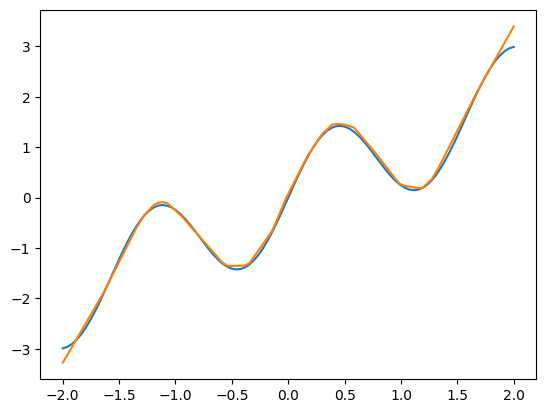

In [18]:
# print predicted values for each of the 100 x values between -2 and 2
# converting to tensor to run it through the model
# then converting it to numpy to plot it 
predictions = [MODEL(torch.tensor(sample).float()) for sample in xvalues.reshape((N,1))]
plt.plot(xvalues, xvalues + np.sin(4*xvalues))
plt.plot(xvalues, np.array([_.detach().numpy() for _ in predictions]));

In [19]:
# functions for to create above performance curve
def make_predictions(X: torch.Tensor, 
                     model: torch.nn.Module) -> List[torch.Tensor]:
    return [model(torch.tensor(sample).float()) 
            for sample in X.reshape((N,1))]

def plot_predictions_versus_ground(X: torch.Tensor, 
                                   y: torch.Tensor, 
                                   y_hat: torch.Tensor,
                                   plot_title: str="line fit") -> None:
    # assumes x and y are both numpy arrays
    # assumes y_hat is generated by make_predictions()
    plt.plot(X, y)
    plt.plot(X, np.array([_.detach().numpy() for _ in y_hat]));
    plt.title(plot_title)

MSE: 0.01
RMSE: 0.11


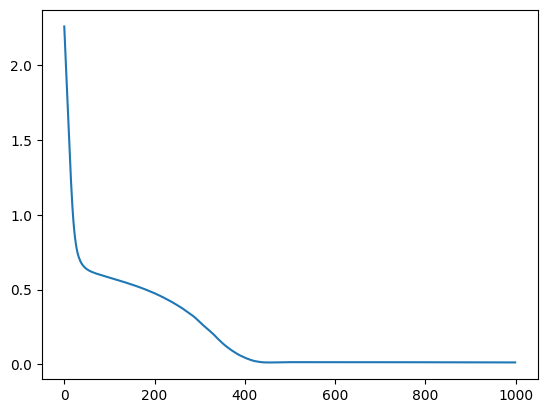

In [20]:
# visualize the mean squared error (mse)
# non-noisy sine wave
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(loss_history)
plt.show()

# Train (noisy data)

In [46]:
reset_env()

/home/matt/Documents/masters-thesis/src/model-2023-05-21 19:39:14.084208.pth


In [47]:
%%time
nprediction_history, nloss_history, nbest_mse, nbest_weights = train_regression_model(MODEL, 
                                                                                      OPT,
                                                                                      noisy_X_train, 
                                                                                      noisy_y_train, 
                                                                                      noisy_X_test, 
                                                                                      noisy_y_test, 
                                                                                      save_path=PATH,
                                                                                      n_epochs=1000, 
                                                                                      batch_size=1, 
                                                                                      show_progress=False)

CPU times: user 1min 16s, sys: 2.81 ms, total: 1min 16s
Wall time: 35 s


MSE: 0.05
RMSE: 0.21


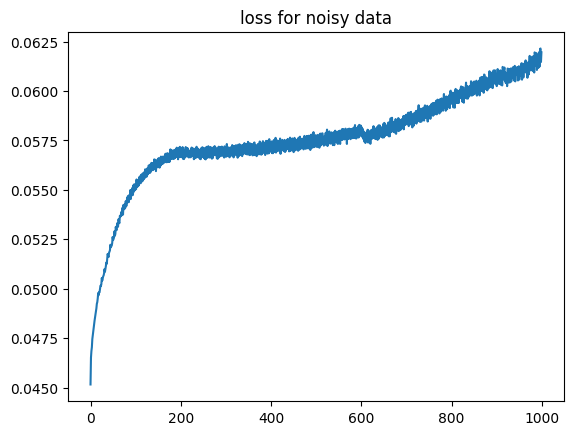

In [48]:
# noisy sine wave
print("MSE: %.2f" % nbest_mse)
print("RMSE: %.2f" % np.sqrt(nbest_mse))
plt.title("loss for noisy data")
plt.plot(nloss_history)
plt.show()

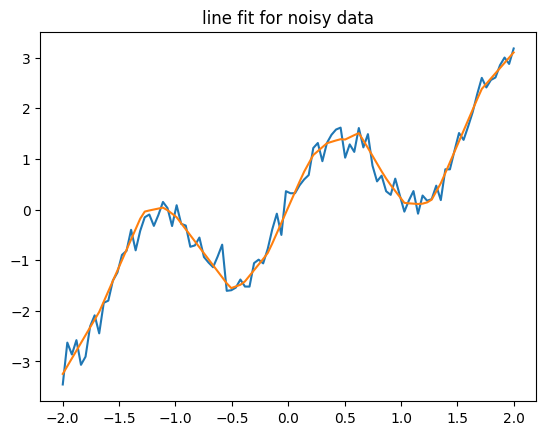

In [49]:
predictions = make_predictions(x, MODEL)
plot_predictions_versus_ground(x, noisy_sine_wave, predictions, plot_title="line fit for noisy data")

# Reinforcement Meta-Learning

3 classes
- layer pool
- target network -- composed of layers from layer pool
- meta learner -- decides which layers from layer pool to add to target network

So, (meta learner) -> (layer pool) -> (target network)

In [21]:
class LayerPool:
    def __init__(self, 
                 in_features: int,
                 num_layers: int=NUM_LAYERS, 
                 num_nodes_per_layer: int=NUM_NODES) -> List[np.ndarray]:
        self.num_layers = num_layers
        self.num_nodes_per_layer = num_nodes_per_layer
        # pre-initialize all layers in dict as 'layer_id' : layer, with xavier uniform
        self.layers = [torch.nn.Linear(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer) 
                       for i in range(num_layers)]
        [torch.nn.init.xavier_uniform(layer.weight) for layer in self.layers]
        self.initial_layer = torch.nn.Linear(in_features, NUM_NODES)
        torch.nn.init.xavier_uniform(self.initial_layer.weight)
    
    def update_layer(self, 
                     layer_idx: int, 
                     layer: torch.nn.Linear) -> None:
        # called by agent after gradient update is made to layer
        # TODO(ms): updating each layer means looping through layers in TargetNetwork instance
        #           and knowing what index each of these layers corresponds to in the original LayerPool instance
        self.layers[layer_idx] = layer

    def get_layer(self,
                  layer_idx: int) -> torch.nn.Linear:
        # called by target modes[layer_idx]l to get the next layer for architecture
        return self.layer

In [25]:
class TargetNetwork(gym.Env, Module):
    '''
    Contains the states and the rewards for those states. In this context,
    this is where the 'target' model for the task is constructed. If mode is
    set to 'train' then some preset # of layers is used to 
    
    step() returns the next state (the next layer) and reward (the negative loss)
    reset() returns an initial state and the info dict
    '''
    def __init__(self, 
                 X: np.ndarray,
                 y: np.ndarray,
                 out_features,
                 layer_pool: LayerPool,
                 num_layers: int,
                 num_nodes_per_layer: int,
                 opt: torch.optim):
        super(TargetNetwork, self).__init__()

        # required by gym interface
        self.observation_space = Box(low=float('-inf'), high=float('inf'), shape=(num_nodes_per_layer,))
        self.action_space = Box(low=0., high=1., shape=(num_layers,)) # TODO(ms): add +1 for the 'no layer' option

        # data 
        self.X = X
        self.y = y
        self.curr_i = 0
        self.curr_x = torch.Tensor( [X[0]] ) # these parameterize the parameterized state (i.e., layer has parameters, and x passed through has value/parameter)
        self.curr_y = torch.Tensor( [y[0]] ) # these parameterize the parameterized state (i.e., layer has parameters, and x passed through has value/parameter)
        self.layer_pool = layer_pool

        # nn module
        # https://discuss.pytorch.org/t/how-to-add-a-layer-to-an-existing-neural-network/30129/3
        self.fc1 = self.layer_pool.initial_layer
        self.fcs = torch.nn.ModuleList([])
        self.out = torch.nn.Linear(NUM_NODES, out_features)
        self.fcs_indices = []
        self.loss_fn = torch.nn.MSELoss()
        self.state = self.reset() # should this include the loss of the model too?

        # test
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(1, 24),
                        torch.nn.ReLU(),
                        torch.nn.Linear(24, 24), # hidden layer 1
                        torch.nn.ReLU(),
                        torch.nn.Linear(24, 24), # hidden layer 2
                        torch.nn.ReLU(),
                        torch.nn.Linear(24, 1)
                    )
        self.opt = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def run_inner_loop(self): # "see how target network performs with outer loop's action"
        '''
        Grabs (x, y)s f, since 'step()' can't be passed (x,y)s.
        This is because it needs to exactly implement the definition as specified in gym.
        This state is captyred by 'curr_x' and 'curr_y'.
        '''
        # update data state 
        self.curr_i  = (self.curr_i + 1) % len(self.X) # go through data multiple times / dataset does not dictate truncation condition
        self.curr_x = torch.Tensor( [self.X[self.curr_i]] ) 
        self.curr_y = torch.Tensor( [self.y[self.curr_i]] )

        # get next state
        # _x = torch.nn.functional.relu(self.fc1(self.curr_x))
        # for i in range(len(self.fcs)):
        #     _x = torch.nn.functional.relu(self.fcs[i](_x))
        # s_prime = _x
        # y_hat = self.out(_x)
       
        s_prime = torch.nn.functional.relu(self.fc1(self.curr_x)) 
        self.model.train()
        y_hat = self.model(self.curr_x)
        
        # get reward
        y = self.curr_y
        loss = self.loss_fn(y, y_hat)
        print(f'yhat {y_hat}, y {y}')
        reward = loss

        # update the layers' parameters in layer pool instance
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        # for i, layer in zip(self.fcs_indices, self.fcs):
        #     self.layer_pool.layers[i] = layer

        return s_prime.detach().numpy().T.squeeze(), float(reward.detach().numpy())

    def reset(self) -> np.ndarray:
        # Returns initial state (as the same type 'observation_space' is) and any 
        # additional info (as a dict, the same as returned by step).
        # initial_state = torch.nn.functional.relu(self.fc1(self.curr_x))

        # test
        initial_layer = torch.nn.Linear(1, NUM_NODES)
        initial_state = initial_layer(self.curr_x)

    
        return initial_state.detach().numpy().T.squeeze() # TODO(ms): is there a better way to massage this data?
    
    def step(self, action: np.ndarray) -> Tuple[torch.Tensor, int, bool, dict]: # "given some new layer"
        # store index to be able to update the layer in the pool later
        # next layer is represented by argmax of return probabilities
        fc_index = np.argmax(action)
        self.fcs_indices.append(fc_index)

        # compose layer to model and get s' and r from the model
        next_layer = self.layer_pool.layers[fc_index] 
        self.fcs.append(next_layer)
        s_prime, reward = self.run_inner_loop()

        # temporary terminate logic
        done = False

        return (
            s_prime,
            reward, 
            done, 
            {}
        )
    
    def render(self, mode='human', close=False):
        print(f'[INFO] # of layers {len(self.fcs)}')

    def close(self):
        pass

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        # use composed target network to make a prediction
        # _x = torch.nn.functional.relu(self.fc1(x))
        # for i in range(len(self.fcs)):
        #     _x = torch.nn.functional.relu(self.fcs[i](_x))
        # return self.out(_x)

        self.model.eval()
        return self.model(x)

In [26]:
# class ReinforcementMetaLearning:
#     '''
#     Meta-policy. The parameters are learned by training on multiple different tasks, where
#     each task is represented by a different dataset (X,y) and is an instance of the 
#     TargetNetwork class.
#     
#     How this works. The meta-policy recieves a state (preliminary output of target network / latent space)
#     and outputs an action (the next layer).
# 
#     Examples usage.
#         $ layer_pool = LayerPool()
#         $ model = ReinforcementMetaLearning(layer_pool, out_features=1)
#         $ model.add_task(X, y)
#         $ model.update_params()
#         $ model.introspect(X, y) # TODO(ms): decide what this will do, then how.
#     
#     https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html#example
#     '''
#     def __init__(self, 
#                  layer_pool,
#                  out_features,
#                  timesteps: int=1000,
#                  device: str='cpu'):
#         self.model = None
#         self.layer_pool = layer_pool
#         self.out_features = out_features
#         self.timesteps = timesteps
#         self.device=device
#     
#     def add_task(self, X, y):
#         new_env = TargetNetwork(X, y, self.out_features, self.layer_pool)
#         stable_baselines3.common.env_checker.check_env(new_env) # check env conforms to gym interface
#         self.curr_env = new_env
#     
#     def update_params(self):
#         '''
#         "Model" or the meta-policy adapts with each new task that a TargetNetwork instance is created 
#         and tuned for.
#         '''
#         if self.model==None:
#             self.model = stable_baselines3.A2C("MlpPolicy", env=self.curr_env, device=self.device)
#         self.model.learn(total_timesteps=self.timesteps)
#         return self.model

In [30]:
%%time

X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

# create (1) LayerPool, (2) TargetNetwork, (3) Metarl instances
layer_pool = LayerPool(in_features)
env = TargetNetwork(
    X, 
    y, 
    out_features, 
    layer_pool, 
    NUM_LAYERS,
    NUM_NODES,
    OPT
    )
stable_baselines3.common.env_checker.check_env(env)

metarl = A2C('MlpPolicy', env)
metarl.learn(total_timesteps=15000)          
target_network_weights = copy.deepcopy(env.model.state_dict())

/tmp/ipykernel_4155/3297747093.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  [torch.nn.init.xavier_uniform(layer.weight) for layer in self.layers]
/tmp/ipykernel_4155/3297747093.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.initial_layer.weight)


yhat tensor([0.2058], grad_fn=<AddBackward0>), y tensor([-2.9595])
yhat tensor([0.2018], grad_fn=<AddBackward0>), y tensor([-2.9035])
yhat tensor([0.1979], grad_fn=<AddBackward0>), y tensor([-2.8219])
yhat tensor([0.1941], grad_fn=<AddBackward0>), y tensor([-2.7158])
yhat tensor([0.1903], grad_fn=<AddBackward0>), y tensor([-2.5867])
yhat tensor([0.1866], grad_fn=<AddBackward0>), y tensor([-2.4371])
yhat tensor([0.1822], grad_fn=<AddBackward0>), y tensor([-2.2698])
yhat tensor([0.1779], grad_fn=<AddBackward0>), y tensor([-2.0881])
yhat tensor([0.1739], grad_fn=<AddBackward0>), y tensor([-1.8956])
yhat tensor([0.1700], grad_fn=<AddBackward0>), y tensor([-1.6964])
yhat tensor([0.1657], grad_fn=<AddBackward0>), y tensor([-1.4946])
yhat tensor([0.1621], grad_fn=<AddBackward0>), y tensor([-1.2944])
yhat tensor([0.1587], grad_fn=<AddBackward0>), y tensor([-1.0999])
yhat tensor([0.1554], grad_fn=<AddBackward0>), y tensor([-0.9152])
yhat tensor([0.1523], grad_fn=<AddBackward0>), y tensor([-0.74

In [31]:
# # parameters
# for name, layer in env.fcs.named_parameters():
#     print(layer.data)

# print(len(dict(env.fcs.named_parameters())))

In [32]:
# performance
y_hats = []
for x in np.linspace(-2,2,100):
    x = torch.Tensor([x])
    y_hat = env.model(x)
    y_hats.append(y_hat)
print(y_hats)

[tensor([-2.2132], grad_fn=<AddBackward0>), tensor([-2.1663], grad_fn=<AddBackward0>), tensor([-2.1186], grad_fn=<AddBackward0>), tensor([-2.0687], grad_fn=<AddBackward0>), tensor([-2.0180], grad_fn=<AddBackward0>), tensor([-1.9670], grad_fn=<AddBackward0>), tensor([-1.9161], grad_fn=<AddBackward0>), tensor([-1.8651], grad_fn=<AddBackward0>), tensor([-1.8142], grad_fn=<AddBackward0>), tensor([-1.7632], grad_fn=<AddBackward0>), tensor([-1.7123], grad_fn=<AddBackward0>), tensor([-1.6613], grad_fn=<AddBackward0>), tensor([-1.6104], grad_fn=<AddBackward0>), tensor([-1.5594], grad_fn=<AddBackward0>), tensor([-1.5085], grad_fn=<AddBackward0>), tensor([-1.4575], grad_fn=<AddBackward0>), tensor([-1.4066], grad_fn=<AddBackward0>), tensor([-1.3556], grad_fn=<AddBackward0>), tensor([-1.3047], grad_fn=<AddBackward0>), tensor([-1.2537], grad_fn=<AddBackward0>), tensor([-1.2027], grad_fn=<AddBackward0>), tensor([-1.1518], grad_fn=<AddBackward0>), tensor([-1.1052], grad_fn=<AddBackward0>), tensor([-1

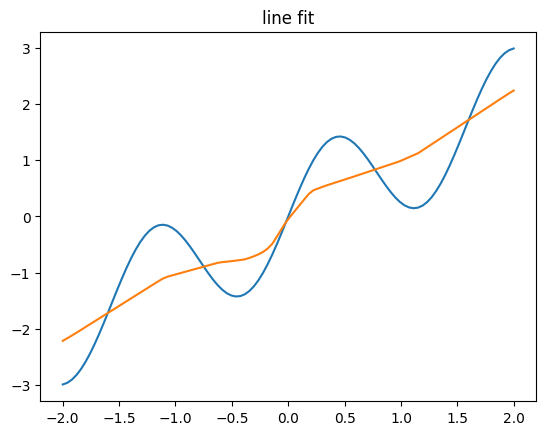

In [33]:
plot_predictions_versus_ground(np.linspace(-2,2,100), sine_wave, y_hats)

# parameters may not be updated
# unclear how many layers there are
# still strange that every prediction is the same
# it keeps adding layers it doesn't stop
# I don't have good visibility into progress
# I don't have good visibility into performance